# BDM Exam Project - Part 2

## TODO:
TASK 0
- [x] DONE

TASK1
- [x] DONE

TASK2
- [X] Implementare Opzione #1
- [X] Implementare Opzione (#2,#3 QUESTE DUE CONTROLLARE SE GIà FUNZIONA), (#4 ANCORA DA IMPLEMENTARE LDA)
- Implementare Opzione #5
- Implementare Opzione #6


TASK3
- Implementare Opzione #1
- [X] Implementare Opzione (#2,#3 QUESTE DUE CONTROLLARE SE GIà FUNZIONA), (#4 ANCORA DA IMPLEMENTARE LDA)
- Implementare Opzione #5
- Implementare Opzione #6
- NOTA BENE: le 3 parti devono funzionare senza cambiare codice (indifferentemente da cosa abbiamo scelto prima, l'input per la parte 4 DEVE essere sempre lo stesso)

TASK4
- MOSTRARE COME GRUPPI IL NOME DEI MEMBRI E NON IL LORO VETTORE
- [x] DONE

TASK 5
- Suddividere i dati in train (+label) e test
- [x] DONE


## Imports

In [ ]:
# General utils
import os
import shutil
import numpy as np

# per i plot
import plotly.express as px
import plotly.graph_objects as go
# ---------- ---------- ---------- ---------- ----------

# My general utils
from my_utils import get_files_name
# ---------- ---------- ---------- ---------- ----------

# Task 0
from task0_utils import task0_stats
# Parte A
from task0_utils import generate_alphabet
from task0_utils import update_alphabet
from task0_utils import gesture_2_word
from task0_utils import write_word_as_json
from task0_utils import generate_dizionario_parole_from_gesturewordsdict
# Parte B
from task0_utils import gesture_words_preprocessing
from task0_utils import show_gesture_metrics
# ---------- ---------- ---------- ---------- ----------

# Task 1
from task1_utils import read_gesture_measures_reduced
from task1_utils import metrics_reduced_2_numpy
from task1_utils import metrics_numpy_2_pandas
from task1_utils import metrics_numpy_2_PCA
from task1_utils import metrics_numpy_2_LDA
from task1_utils import metrics_numpy_2_SVD
from task1_utils import get_top_k_latent_features
from task1_utils import prepare_alg_variances_to_plot
# ---------- ---------- ---------- ---------- ----------

# Task 2
from task2_utils import read_words_data_ed_dtw
from task2_utils import find_k_most_similar_dp
from task2_utils import find_k_most_similar_tksem
from task2_utils import find_k_most_similar_ed
from task2_utils import find_k_most_similar_dtw
# ---------- ---------- ---------- ---------- ----------

# Task 3
from task3_utils import generate_gestures_similarity_matrix
from task3_utils import gestures_similarity_matrix_2_pandas
from task3_utils import generate_gesture_gesture_svd
from task3_utils import get_top_p_latent_gestures
# ---------- ---------- ---------- ---------- ----------

# Task 4
from task4_utils import cluster_labels_2_pandas
from task4_utils import top_p_gestures_2_numpy
# Parte A
from task4_utils import MyPartitioner
# Parte B
from task4_utils import SimpleKMeans
# Parte C
from task4_utils import spectral_clustering_analyze
from task4_utils import spectral_analisys_results_2_pandas
from task4_utils import spectral_analisys_results_pandas_2_split
from task4_utils import spectral_clustering
# ---------- ---------- ---------- ---------- ----------

# Task 5
from task5_utils import database_numpy_2_supervised_data
from task5_utils import prepare_test_dataframe

from sklearn.preprocessing import StandardScaler
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# Decision Tree classifier
from sklearn import tree
import graphviz 
# ---------- ---------- ---------- ---------- ----------

## Task 0

In [ ]:
path_csv_directory = '../Dati_2/csv/'

In [ ]:
path_words_directory = '../Dati_2/words/'

In [ ]:
path_vectors_directory = '../Dati_2/vectors/'

Inserire le coordinate che compongono il gesto separate da un trattino:

In [ ]:
input_data_components = 'X-Y-Z-W'

Inserire un valore per R (2R è il numero di simboli dell'alfabeto)

In [ ]:
input_interval_resolution = '5'

In [ ]:
data_components = input_data_components.strip().split("-")
task0_stats["r"] = int(input_interval_resolution.strip())

# Rigenero i vari file path (per words e vectors)
if os.path.exists(path_words_directory):
    shutil.rmtree(path_words_directory)
os.makedirs(path_words_directory)
if os.path.exists(path_vectors_directory):
    shutil.rmtree(path_vectors_directory)
os.makedirs(path_vectors_directory)

In [ ]:
# Mi prendo il nome di tutti i files
gesture_files = get_files_name(path_csv_directory + "X/", ext_filter="csv")
alfabeto = generate_alphabet(gesture_files, data_components, path_csv_directory, task0_stats)

In [ ]:
#print(alfabeto.simboli)
#print(alfabeto.parole)
print("Numero simboli:", alfabeto.n_simboli)
print("Numero parole:", alfabeto.n_parole)

Numero simboli: 10
Numero parole: 63


### Task 0A

In [ ]:
dizionario_gesti_parole = {}

for gesture_file_name in gesture_files:
    gesture_words_dict = gesture_2_word(gesture_file_name, data_components, alfabeto, path_csv_directory)
    # Salvo solo le info necessarie relative alle parole (come richiesto nel testo)
    dizionario_parole_gesture = generate_dizionario_parole_from_gesturewordsdict(gesture_words_dict)

    dizionario_gesti_parole[gesture_file_name.split(".")[0]] = dizionario_parole_gesture
    # Salvo su file il dizionario completo
    write_word_as_json(gesture_words_dict, gesture_file_name, path_words_directory)

In [ ]:
#dizionario_gesti_parole['1']

### Task 0B

In [ ]:
# Mi prendo la lista di tutti i file words
words_files = get_files_name(path_words_directory, ext_filter="wrd")

# CALCOLARE IL NUMERO DI SENSORI (anche se so che ce ne sono 20, in questo modo rimane più parametrico)
n_sensori = 0
for (_, sensor, word), cont in dizionario_gesti_parole[next(iter(dizionario_gesti_parole))].items():
    sensor = int(sensor)
    if n_sensori > sensor: # ho già ciclato una volta su tutti i sensori, è inutile ricontrollare per le altre coordinate
        break
    if n_sensori < sensor:
        n_sensori = sensor
n_sensori += 1 # Correzione dato che i sensori partono da 0 e a me serve sapere quanti ce ne sono

# Eseguo x il nostro dataset
t0b_preprocessing_settings = {
    'dizionario_gesti_parole': dizionario_gesti_parole,
    'data_components': data_components,
    'words_files': words_files,
    'n_sensori': n_sensori,
    'alfabeto': alfabeto,
    'path_words_directory': path_words_directory,
    'path_vectors_directory': path_vectors_directory # mettere a None o a caso se si mette save=False nel metodo
}
# Calcolo TF, IDF, TF-IDF di ogni gesto
gestures_metrics = gesture_words_preprocessing(t0b_preprocessing_settings)

In [ ]:
#show_gesture_metrics(gestures_metrics[0])

## Task 1

In [ ]:
input_task1_gesti_directory = '../Dati_2/csv/'

In [ ]:
input_task1_data_components = 'X-Y-W-Z'

In [ ]:
input_task1_modello_vettoriale = 'Modello TF-IDF'

In [ ]:
t1_data_components = input_task1_data_components.strip().split("-")
t1_gesture_files = get_files_name(input_task1_gesti_directory + t1_data_components[0] + "/", ext_filter="csv")
# Dovremmo eseguire a tutti questi i 2 metodi gesture_2_word e poi word_2_metrics
# Ma ipotizziamo che siano i dati già calcolati ed evitiamo
t1_gesture_files = [g_file.split(".")[0] for g_file in t1_gesture_files] # mi prendo giusto il nome dei vari files

# 1260 con dimensione dei dati (n_sensori * n_parole)
t1_metrics_data = {
    'filename': [],
    'labels': [],
    'data': np.zeros((len(t1_gesture_files), n_sensori * alfabeto.n_parole))
}
for index, gesture_file in zip(range(len(t1_gesture_files)), t1_gesture_files):
    #path_vectors_directory = ../Dati_2/vectors/
    # Leggo le metrice ridotte
    gesture_metrics_reduced = read_gesture_measures_reduced(gesture_file, path_vectors_directory, input_task1_modello_vettoriale)
    # Trasformo la metrica ridotta in un file numpy
    label = 1 # Label 1 per i file 250, 280
    if int(gesture_file) < 100:
        label = 0 # Label 0 per file 1, 30
    elif int(gesture_file) > 400:
        label = 2 # label 2 per i file 560, 590
    metrics_numpy = metrics_reduced_2_numpy(gesture_metrics_reduced, alfabeto)
    t1_metrics_data['filename'].append(gesture_file)
    t1_metrics_data['labels'].append(label)
    t1_metrics_data['data'][index] = metrics_numpy

In [ ]:
#t1_metrics_data

In [ ]:
input_task1_option = 'PCA'

In [ ]:
metrics_pandas = metrics_numpy_2_pandas(t1_metrics_data['data'], alfabeto)
if input_task1_option == "PCA":
    t1_alg_result, t1_alg_variance = metrics_numpy_2_PCA(metrics_pandas, show_intermediate_data=True)
elif input_task1_option == "SVD":
    t1_alg_result, t1_alg_variance = metrics_numpy_2_SVD(metrics_pandas, show_intermediate_data=True)
else:
    t1_alg_result, t1_alg_variance = metrics_numpy_2_LDA(metrics_pandas, t1_metrics_data['labels'], show_intermediate_data=True)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93
S0 -0.937;0.2882,4.610385e-18,1.043900e-17,1.245627e-17,2.825664e-17,2.980386e-17,3.352958e-17,1.857226e-17,1.897614e-17,5.510035e-17,1.843743e-17,...,3.927518e-17,1.386195e-16,6.823295e-17,8.140479e-17,1.708179e-16,2.862053e-17,9.181635e-17,4.361283e-17,9.083483e-17,0.057600
S0 -0.7334;-0.937,1.189318e-17,1.232031e-18,7.741145e-18,6.136546e-18,1.151214e-17,1.634008e-17,1.548882e-17,1.122518e-17,5.392665e-18,3.065228e-17,...,6.511243e-17,2.665348e-17,9.582293e-17,1.060671e-17,4.174341e-17,2.877369e-17,4.104126e-17,6.875764e-18,1.756070e-18,0.064205
S0 0.7334;0.937,6.375441e-18,3.652154e-17,2.327174e-17,3.593858e-17,1.082520e-17,3.370687e-17,1.197098e-17,5.724505e-17,5.580350e-17,1.154491e-17,...,3.542168e-17,4.846195e-17,6.007393e-17,7.332658e-18,2.763577e-17,1.301308e-16,1.415142e-17,5.822984e-17,2.499786e-17,0.021466
S0 0.7334;-0.2882,3.417196e-17,1.251487e-17,4.225771e-17,6.193277e-18,4.084925e-17,1.176042e-18,2.013176e-17,4.878576e-17,1.125643e-16,2.179281e-17,...,5.802098e-17,9.205336e-18,1.258645e-16,1.162510e-16,1.445180e-16,1.064303e-16,2.172564e-16,1.229919e-16,3.992355e-17,0.027781
S0 0.2882;-0.7334,4.663445e-17,1.553051e-17,2.613338e-17,2.188267e-18,1.618431e-17,1.667718e-17,5.430810e-17,1.568084e-17,5.635739e-17,3.398155e-17,...,6.318808e-17,1.120380e-17,2.475047e-18,1.223672e-17,9.785849e-18,1.584316e-17,1.803216e-16,9.844839e-17,1.404902e-16,0.024379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S19 0.937;0.9911,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
S19 0.9911;-0.9911,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
S19 0.937;0.937,1.517414e-03,7.557301e-04,2.937658e-04,5.038445e-04,2.061131e-03,5.647360e-04,1.384269e-03,1.708889e-04,3.704735e-03,1.018911e-05,...,6.119156e-03,2.248186e-03,6.642596e-03,8.042383e-03,2.855752e-05,4.927176e-03,3.733473e-04,1.564952e-02,8.051912e-03,0.001775
S19 -0.9911;-0.9911,4.384721e-02,5.370243e-02,2.842663e-02,1.950291e-02,4.974445e-02,4.621538e-02,3.783455e-02,5.729262e-03,9.263475e-03,1.241031e-02,...,5.214824e-02,3.168236e-02,1.570242e-02,3.053412e-02,4.236152e-02,2.509181e-03,1.615092e-02,2.113285e-02,4.512338e-02,0.025627


['S11 0.7334;0:     0.508574',
 'S11 0;0.7334:     0.365592',
 'S11 0.2882;0.9911:     0.331333',
 'S11 -0.7334;0.2882:     0.296525',
 'S11 -0.7334;0.7334:     0.28136',
 'S10 0.7334;0.2882:     0.22691',
 'S17 0;0.9911:     0.178334',
 'S11 0.7334;-0.2882:     0.176133',
 'S9 -0.937;-0.7334:     0.165609',
 'S5 0;-0.9911:     0.145117']


PC1 top 10 features are: 



In [ ]:
fig = px.scatter(t1_alg_variance,
            labels={"index": "# Components", "value": "Explained Variance"}, 
            title="Explained Variance with increasing number of latent features")
fig.update_traces(showlegend=True)
fig.show()

In [ ]:
t1_top_k_latent_features = '2'

In [ ]:
t1_top_k_latent_features = int(t1_top_k_latent_features)
top_k_features = get_top_k_latent_features(t1_alg_result, t1_top_k_latent_features)
#top_k_features

## Task 2

 Scrivere un programma che, dato un file di gesti, individui i 10 gesti piu’ simili nel database di gesti, 
utilizzado:

In [ ]:
# Preparazione data
t2_data_dp = {'gestures': t1_metrics_data['filename'], 'data': t1_metrics_data['data']}
t2_data_tksem = {'gestures': t1_metrics_data['filename'], 'data': t1_alg_result['fitted_alg']}
# Still TODO
t2_data_ed_dtw = read_words_data_ed_dtw(gesture_files, data_components, alfabeto, path_words_directory)
t2_data_ed = {'gestures': t1_metrics_data['filename'], 'data': t2_data_ed_dtw['ed']}
t2_data_dtw = {'gestures': t1_metrics_data['filename'], 'data': t2_data_ed_dtw['dtw']}

In [ ]:
t2_input_file_gestures = '../Dati_2/words/1.wrd'

In [ ]:
t2_input_k_gestures = '93'

In [ ]:
t2_input_k_latent_features = '60'

In [ ]:
t2_input_query_type = 'Dot Product'

In [ ]:
# X facilità so che già ho calcolato sto file in input e lo prendo dal database
gesture_name_id = t2_input_file_gestures.split("/")[-1].split(".")[0]

query_type = t2_input_query_type
finder_query_settings = {
    'k_latent_features': int(t2_input_k_latent_features),
    'k_gestures_return': int(t2_input_k_gestures),
}

top_k = None
if query_type == 'Dot Product':
    gesture_numpy = t2_data_dp['data'][t2_data_dp['gestures'].index(gesture_name_id)]
    top_k = find_k_most_similar_dp(t2_data_dp, gesture_numpy, finder_query_settings)
elif query_type == 'Top-K Semantiche Latenti':
    gesture_numpy = t2_data_tksem['data'][t2_data_tksem['gestures'].index(gesture_name_id)]
    # Preparo la query con gli input scelti dall'utente
    top_k = find_k_most_similar_tksem(t2_data_tksem, gesture_numpy, finder_query_settings)
elif query_type == 'Edit Distance':
    #gesture_numpy = t2_data_ed['data'][t2_data_ed['gestures'].index(gesture_name_id)]
    #top_k = find_k_most_similar_ed(t2_data_ed, gesture_numpy, finder_query_settings)
    print("Edit Distance not implemented yet!")
else:
    #gesture_numpy = t2_data_dtw['data'][t2_data_dtw['gestures'].index(gesture_name_id)]
    #top_k = find_k_most_similar_dtw(t2_data_dtw, gesture_numpy, finder_query_settings)
    print("Distanza DTW not implemented yet!")

if top_k is not None:
    print("Top " + t2_input_k_gestures + " gestures più simili a '" + t2_input_file_gestures + "', usando '" + query_type + "':")
    print(top_k)

Top 93 gestures più simili a '../Dati_2/words/1.wrd', usando 'Dot Product':
   gesture  similarity
0        1    1.000000
1      559    0.968143
2      569    0.680727
3      249    0.565666
4      262    0.299952
..     ...         ...
88     268    0.021317
89      30    0.020417
90     587    0.019296
91     582    0.017035
92      24    0.014780

[93 rows x 2 columns]


## Task 3

In [ ]:
t3_input_query_type = 'Top-K Semantiche Latenti'

In [ ]:
query_type = t3_input_query_type

# Creo la matrice di similarità gesture - gesture (in base a come ha scelto l'utente di procedere)
gesture_sim_matrix = None
if query_type == 'Dot Product':
    #gesture_sim_matrix = generate_gestures_similarity_matrix(alg_database['data'], int(t2_input_k_latent_features))
    print("Distanza DTW not implemented yet!")
elif query_type == 'Top-K Semantiche Latenti':
    gesture_sim_matrix = generate_gestures_similarity_matrix(t2_data_tksem['data'], int(t2_input_k_latent_features))
elif query_type == 'Edit Distance':
    #gesture_sim_matrix = generate_gestures_similarity_matrix(alg_database['data'], int(t2_input_k_latent_features))
    print("Edit Distance not implemented yet!")
else:
    #gesture_sim_matrix = generate_gestures_similarity_matrix(alg_database['data'], int(t2_input_k_latent_features))
    print("Distanza DTW not implemented yet!")

# La trasformo in dataframe pandas (così ho anche il nome delle gestures a confronto nelle righe / colonne)
gestures_sim_matrix_pd = gestures_similarity_matrix_2_pandas(gesture_sim_matrix, t2_data_tksem['gestures'])
print("Matrice similarità gesture-gesture:")
gestures_sim_matrix_pd

Matrice similarità gesture-gesture:


,1,10,11,12,13,14,15,16,17,18,...,584,585,586,587,588,589,6,7,8,9
1,1.000000,0.180633,0.220684,0.194274,0.775617,0.106529,0.210021,0.614872,0.000000,0.672543,...,0.391180,0.197496,0.743870,0.776624,0.214130,0.530594,0.454619,0.680948,0.165243,0.428503
10,0.180633,1.000000,0.134252,0.149315,0.410824,0.092439,0.142059,0.307684,0.111953,0.352458,...,0.261560,0.193946,0.452579,0.398142,0.185634,0.369915,0.243104,0.380008,0.234891,0.233064
11,0.220684,0.134252,1.000000,0.232046,0.420095,0.074161,0.088449,0.436875,0.070138,0.401440,...,0.250474,0.183127,0.401670,0.418044,0.157407,0.323626,0.309256,0.406643,0.109123,0.333103
12,0.194274,0.149315,0.232046,1.000000,0.363477,0.026244,0.051106,0.346658,0.007494,0.353070,...,0.178747,0.154716,0.367784,0.369603,0.195258,0.335831,0.277719,0.359612,0.101580,0.205392
13,0.775617,0.410824,0.420095,0.363477,1.000000,0.091823,0.190306,0.550808,0.000000,0.632039,...,0.399239,0.185411,0.776297,0.821540,0.178224,0.555267,0.470282,0.787582,0.168651,0.417820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.530594,0.369915,0.323626,0.335831,0.555267,0.254810,0.271668,0.600682,0.216406,0.487442,...,0.406847,0.375834,0.679463,0.547926,0.287686,1.000000,0.350554,0.585813,0.114163,0.336364
6,0.454619,0.243104,0.309256,0.277719,0.470282,0.132360,0.169715,0.396070,0.136314,0.375931,...,0.303774,0.238880,0.446796,0.428957,0.272798,0.350554,1.000000,0.521654,0.154627,0.369415
7,0.680948,0.380008,0.406643,0.359612,0.787582,0.250903,0.394035,0.573685,0.299266,0.611216,...,0.493288,0.360351,0.704283,0.703822,0.350883,0.585813,0.521654,1.000000,0.155013,0.381513
8,0.165243,0.234891,0.109123,0.101580,0.168651,0.083309,0.089439,0.161905,0.200977,0.123399,...,0.144379,0.100219,0.123448,0.074277,0.131889,0.114163,0.154627,0.155013,1.000000,0.140159


In [ ]:
# Faccio svd con 93 componenti (e poi mi prendo solo quelle che servono)
n_components = 92
svd_latent_gestures, svd_variance = generate_gesture_gesture_svd(gestures_sim_matrix_pd, n_components=n_components)

In [ ]:
t3_query_top_p = '5'

In [ ]:
t3_query_top_p = int(t3_query_top_p)
# Input value check
if t3_query_top_p < 1:
    t3_query_top_p = 1
elif t3_query_top_p > n_components:
    t3_query_top_p = n_components

# Tiro fuori le top p gestures latenti
top_p_gestures = get_top_p_latent_gestures(svd_latent_gestures, t3_query_top_p)

In [ ]:
#top_p_gestures

## Task 4

In [ ]:
t4_p_partitions = '3'

In [ ]:
t4_p_partitions = int(t4_p_partitions)
# Input value check
if t4_p_partitions < 1:
    t4_p_partitions = 1

### Task 4A

Partizionamento top_p_gestures in base ai loro gradi di appartenenza alle p semantiche

In [ ]:
# Preparo i dati

# Dati reali (le top p gestures appena calcolate)
# Essendo le top p gestures in un 'formato strano' le traduco in un array numpy (sono una lista di dizionari di liste)
X_train = top_p_gestures_2_numpy(top_p_gestures, t3_query_top_p, t1_metrics_data['filename'])
X_test = [X_train[0]] # Prendo un dato a caso giusto x testare la predict
#X_test = [np.array([0.5, 0.2, 0.3, 0.7, 0.1])] # Un esempio a caso deve avere p dimensioni (se non presente fra i dati deve dare None)

# Semplice esempio di test su 2 dimensioni
#X_train = [np.array([1, 1]), np.array([2, 2]), np.array([3, 3]), np.array([4, 1]), np.array([1, 2]), np.array([-1, -2]), np.array([5, 2])]
#X_test = [np.array([4, 1]), np.array([4, 2])]

In [ ]:
# Creo e fitto il partizionatore selezionando t4_p_partitions come numero di gruppi da creare
partitioner = MyPartitioner(t4_p_partitions, max_iterations=5)
partitioner.fit(X_train)
#partitioner.fit(gesture_sim_matrix)
print("Dimensione spazio:", partitioner.groups_space_dimension)
#print("Gruppi:\n", partitioner.groups)

Dimensione spazio: 7.345523888943749


In [ ]:
print("Predizione gruppi:", partitioner.predict(X_test))

Predizione gruppi: [([0.1386, 0.1524, 0.0495, 0.0575, 0.1492], 2)]


### Task 4B

Clustering matrice similarità gesture-gesture con un algoritmo basato sul k-means (scritto da noi)

In [ ]:
# Settings del k-means
k = 5 # numero clusters
min_tolerance = 0.1 #meno di 10% differenza va bene
max_iterations = 5 # max numero di iterazioni

# Generazione dati fasully, giusto x testare
#X_train = np.array([[1, 2, 3],[1, 4, 5],[2, 7, 4],[3, 9, 2],[5, 5, 5]])
#X_test = np.array([2, 1, 1])

# Oppure uso dati reali
X_train = gestures_sim_matrix_pd.to_numpy()
# per test del data, sono 60x60
X_test = X_train[0:10] # Prendo tot elementi del training data e provo poi a predirli, o sotto predico un elemento nuovo
#X_test = [np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]

In [ ]:
# Creazione e fit dell'algoritmo
kmean = SimpleKMeans(k=k, min_tolerance=min_tolerance, max_iterations=max_iterations)
kmean.fit(X_train)

In [ ]:
# Predizione dati
predictions = kmean.predict(X_test)
print(predictions)

[0, 2, 2, 2, 0, 1, 4, 0, 1, 0]


### Task 4C

Clustering matrice similarità gesture-gesture con un algoritmo di clustering spettrale basato sulla matrice laplaciana

In [ ]:
analysys_spectral_results = spectral_clustering_analyze(gestures_sim_matrix_pd, max_clusters=15)
analysys_spectral_results = spectral_analisys_results_2_pandas(analysys_spectral_results, gestures_sim_matrix_pd)

In [ ]:
# Plot clusters sankey
source, target, value = spectral_analisys_results_pandas_2_split(analysys_spectral_results)
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = list(set(source).union(set(target))),
        color = "blue"
    ),
    link = dict(
        source = source,
        target = target,
        value = value
    )
)])

fig.update_layout(title_text="Spectral Clustering Evolution", font_size=10)
fig.show()

In [ ]:
generated_cluster_labels = spectral_clustering(gestures_sim_matrix_pd, n_clusters=t4_p_partitions)#, offset=44) # Usare offset se vogliamo mostrare i nomi dei cluster mostrati nel sankey, offset=44 per n_clusters=10
clustering_labels = [str(elem) for elem in set(generated_cluster_labels)] # All the cluster names
cluster_labels_full = cluster_labels_2_pandas(generated_cluster_labels, gestures_sim_matrix_pd.columns)

In [ ]:
print("Cluster Names:", clustering_labels)
print("\nClustering Result:\n", generated_cluster_labels)
## In caso si voglia far vedere per bene le accoppiate (Gesture X, Label Y)
print("\nClustering Results(full info):\n", cluster_labels_full)

Cluster Names: ['0', '1', '2']

Clustering Result:
 [0 0 1 1 0 2 2 0 2 0 0 0 2 0 1 2 2 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0
 1 1 0 1 1 1 1 0 0 2 1 1 1 0 1 2 2 2 1 0 2 0 2 2 1 1 1 0 2 1 1 0 1 2 1 1 1
 1 1 1 2 2 1 2 1 2 1 1 2 2 1 1 1 2 1 1]

Clustering Results(full info):
 [{'Gesture': '1', 'Label': 0}, {'Gesture': '10', 'Label': 0}, {'Gesture': '11', 'Label': 1}, {'Gesture': '12', 'Label': 1}, {'Gesture': '13', 'Label': 0}, {'Gesture': '14', 'Label': 2}, {'Gesture': '15', 'Label': 2}, {'Gesture': '16', 'Label': 0}, {'Gesture': '17', 'Label': 2}, {'Gesture': '18', 'Label': 0}, {'Gesture': '19', 'Label': 0}, {'Gesture': '2', 'Label': 0}, {'Gesture': '20', 'Label': 2}, {'Gesture': '21', 'Label': 0}, {'Gesture': '22', 'Label': 1}, {'Gesture': '23', 'Label': 2}, {'Gesture': '24', 'Label': 2}, {'Gesture': '249', 'Label': 0}, {'Gesture': '25', 'Label': 1}, {'Gesture': '250', 'Label': 0}, {'Gesture': '251', 'Label': 0}, {'Gesture': '252', 'Label': 1}, {'Gesture': '253', 'Label': 0}, {'Gestur

## Task 5 

In [ ]:
# Genero il dataframe pandas a partire dai dati e dalle loro labels
(X_train_df, y_train_df), (X_test_df, y_test_df), reshaped_features_names = database_numpy_2_supervised_data(t1_alg_result['fitted_alg'])

# Fitto un normalizzatore sui dati di train
scaler = StandardScaler()
scaler.fit(X_train_df)
# Normalizzo i dati di train
X_train = scaler.transform(X_train_df)
y_train = y_train_df.values.ravel()

TypeError: database_numpy_2_supervised_data() missing 1 required positional argument: 'labels'

In [ ]:
# Preparo i dati di test
#test_data = [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]]
# Eseguo reshape dei dati (rendo le matrici in righe, come viene fatto anche x quello di train)
test_data = t5_alg_database['np_database']
test_data = np.transpose(test_data,(0,1,2)).reshape(test_data.shape[0],-1)
X_test_df = prepare_test_dataframe(test_data, reshaped_features_names)

# Normalizzo i dati di test
X_test = scaler.transform(X_test_df)

### Classificazione con k-nearest neighbor

In [ ]:
# Addestro il classificatore
n_neighbors = 5 # Numero di vicini che uso x decidere la label
classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# Predico
y_pred = classifier.predict(X_test)
print("("+str(n_neighbors)+")NN - Predictions:\n", y_pred)

(5)NN - Predictions:
 [1 0 0 2 0 1 2 1 2 1 0 1 0 0 0 2 1 1 1 1 1 0 0 1 1 0 1 1 2 0 1 0 1 0 2 0 1
 0 2 0 0 1 1 0 1 1 0 1 2 0 1 1 1 1 2 0 1 0 0 1 1 1 1 1 1 1 1 0 2 1 0 0 0 0
 1 1 0 1 1 2 1 1 1 0 1 0 0 0 1 1 1 1 1]


### Classificazione con decision tree

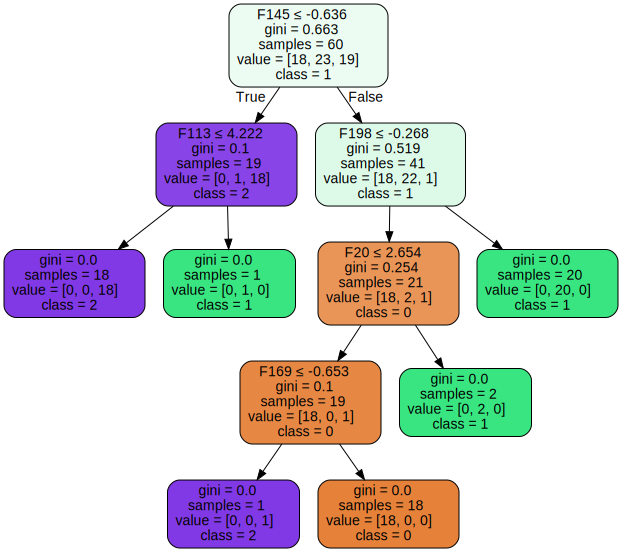

In [ ]:
# Addestro l'albero di decisione
clf = tree.DecisionTreeClassifier()#(max_depth=10)
clf = clf.fit(X_train, y_train)

# Eseguo il plot dell'albero di decisione creato
dot_data = tree.export_graphviz(clf, out_file=None,
    feature_names=reshaped_features_names,
    class_names=clustering_labels, #['Ugo', 'Federico', 'D.Va'],
    filled=True, rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
# Predico con l'albero di decisione
y_pred = clf.predict(X_test)
print("DT - Predictions:\n", y_pred)

DT - Predictions:
 [1 2 0 2 1 2 2 2 2 2 2 0 0 1 0 2 2 0 2 1 1 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2
 2 1 1 2 0 2 2 0 1 2 2 2 2 0 2 2 2 2 2 0 1 1 1 0 0 2 2 2 1 1 2 2 2 2 2 2 2
 0 1 0 2 0 2 2 2 2 2 2 0 2 1 2 1 0 2 2]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=81dda25b-3b1c-4959-acc8-4a8b980be717' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>